#  텍스트 기반 사기 탐지

- 테스트 환경 MAC M1
    - 파이썬 3.10.10
    - huggingface        0.0.1
    - nltk               3.8.1
    - numpy              1.24.2
    - pandas             2.0.0
    - torch              1.12.1
    - transformers       4.27.4

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import tqdm
import itertools

# 플랏 한글(맥)
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 자연어(영어) 전처리 모듈
import nltk
from nltk import tokenize  
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# 자연어 분포 확인용 모듈
from nltk import FreqDist, Text
from wordcloud import WordCloud

#
from transformers import pipeline



/Users/yurikim/micromamba/envs/py_3_10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 데이터 불러오기

In [2]:
data = pd.read_csv(glob.glob(os.getcwd()+'/data07**')[0])

# 비어있는 행 삭제 & 단어 길이 컬럼 추가
data = (
    data
    .loc[lambda x : x['Text'].notnull()]
    .assign(TextLength=lambda x : x['Text'].apply(lambda y : len(y)))
)

## 2. 분포 확인

In [3]:
display(data.sample(10))
print(data['Class'].value_counts())

,Text,Class,TextLength
6849,Madame Secretary:Pardon the early morning emai...,0,769
9668,HolbrookeRC@state.gov,0,21
6818,FROM THE DESK OF RAJI RAJIBILL AND EXCHANGE MA...,1,2966
4062,"99 35<BR>&nbsp;<BR>&nbsp;<BR>Dear Sir/Madam,<B...",1,3718
1061,Can you pls send me a copy for today?,0,37
11733,NiceForgot to tell you about our harrowing cir...,0,89
8555,Pis add Jackie Newmyer and Mayor Nutter (215-6...,0,108
5584,I'm in bad cell area.,0,21
10624,"From Nomy bamba Abidjan, Ivory Coast West ...",1,1584
3802,"Goodday,Thanks for your response to my email. ...",1,674


Class
0    6742
1    5186
Name: count, dtype: int64


In [4]:
print("> 정상 메일")
display(data[data['Class']==0].sample(3))
print("> 사기 메일")
display(data[data['Class']==1].sample(3))

> 정상 메일


,Text,Class,TextLength
3393,Statement on the Death of American Personnel i...,0,2067
11761,Thx for the changes you made. A few questions:...,0,374
1971,Does this mean you have to go to Cuba and arre...,0,97


> 사기 메일


,Text,Class,TextLength
8157,"Hello dearFrom, Miss ZACHI MedineAbidjan Cote ...",1,1753
7011,">From Cynthia.Dearest one,GREETNGS,Permit me t...",1,1853
11518,"Hello Sir/Madam, firstly I will like to introd...",1,3409


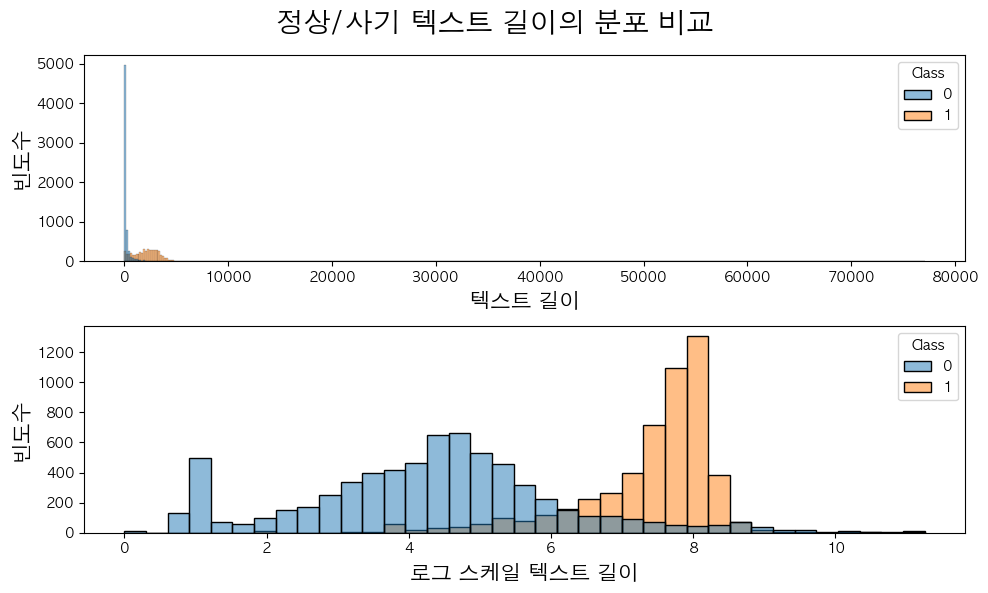

In [5]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
sns.histplot(x=data['TextLength'], hue=data['Class'])
plt.xlabel("텍스트 길이", size=15)
plt.ylabel("빈도수", size=15)

plt.subplot(2,1,2)
sns.histplot(x=np.log(data['TextLength']), hue=data['Class'])
plt.xlabel("로그 스케일 텍스트 길이", size=15)
plt.ylabel("빈도수", size=15)
plt.suptitle("정상/사기 텍스트 길이의 분포 비교", size=20)
plt.tight_layout()
plt.show()

## 전처리 
ex. 예제 원본 문장 "Supply Quality China's EXCLUSIVE dimensions at Unb"
1. 표준화
    - 전체 소문자 처리
    - 처리예제. "supply quality china's exclusive dimensions at unb"
2. 토크나이징
    - 줄바꿈, 띄어쓰기 정도만 분리
    - 처리예제. ['Supply', 'Quality', 'China', "'s", 'EXCLUSIVE', 'dimensions', 'at', 'Unbeatable', 'Price.Dear', 'Sir', ',', 'We']
3. Punctuation 제거
    - 정규표현식으로 콤마 등 삭제
    - 처리예제. ['Supply', 'Quality', 'China', "s", 'EXCLUSIVE', 'dimensions', 'at', 'Unbeatable', 'Price.Dear', 'Sir', 'We']
4. 어간 추출(Stem)
    - 처리예제. ['suppli', 'qualiti', 'china',  "'s", 'exclus', 'dimens', 'unbeat', 'price.dear', 'sir', ',', 'pleas', 'inform']
5. Stopwords 제거

- 위 내용 코드로 한번에 처리하기
```python
   tokens_normal = []
    index_normal = (
        data
        .loc[lambda x : x['Class']==0]
        .index
    )
    for idx in tqdm(index_normal) : 
        token = [x for x in retokenize.tokenize(data['Text'].str.lower()[idx]) if x not in stopwords.words('english')]
        tokens_normal += token
```

- 참고. 캐싱
    - dill 패키지 이용

In [10]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/yurikim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yurikim/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
# LookupError 발생시 다음 실행
# nltk.download('all')
print("1. 표준화")
print('   ', data['Text'].str.lower()[0][:50])

print("2. 토크나이징")
print('   ', tokenize.word_tokenize(data['Text'][0])[:12])

print("3. Punctiation 제거")
retokenize = tokenize.RegexpTokenizer("[\w]+")
print('   ', retokenize.tokenize(data['Text'][0])[:12])

print("4. Stopwords 제거")
print('영어 stopwords 예 >', random.sample(stopwords.words('english'),7))
st = PorterStemmer()
print('   ', [st.stem(x) for x in tokenize.word_tokenize(data['Text'].str.lower()[0]) 
       if x not in stopwords.words('english')][:12])


1. 표준화
    supply quality china's exclusive dimensions at unb
2. 토크나이징
    ['Supply', 'Quality', 'China', "'s", 'EXCLUSIVE', 'dimensions', 'at', 'Unbeatable', 'Price.Dear', 'Sir', ',', 'We']
3. Punctiation 제거
    ['Supply', 'Quality', 'China', 's', 'EXCLUSIVE', 'dimensions', 'at', 'Unbeatable', 'Price', 'Dear', 'Sir', 'We']
4. Stopwords 제거
영어 stopwords 예 > ['wouldn', 'aren', 'm', 'own', 'about', 'was', 'don']
    ['suppli', 'qualiti', 'china', "'s", 'exclus', 'dimens', 'unbeat', 'price.dear', 'sir', ',', 'pleas', 'inform']


In [12]:
sample_ratio = 1000/len(data)

ind = []
for i in range(2):
    ind_list = list(data[data['Class']==i].index)
    ind = ind + random.sample(ind_list, int(sample_ratio*len(ind_list)))
ind = np.sort(ind)
data = data.iloc[ind,:].reset_index(drop=True)

In [13]:
data['Class'].value_counts()

Class
0    554
1    445
Name: count, dtype: int64

### 3.1. 표준화

In [14]:
check_ind = random.sample(range(len(data)),3)

In [15]:
data['Text'] = data['Text'].str.lower()
display(data.iloc[check_ind,:])

,Text,Class,TextLength
586,>from the desk of bala tomson (esq).the head o...,1,3411
218,<div><div>for your kind attention.</div><div>k...,1,1354
895,worth a read.,0,13


### 3.2. 토크나이징

3.3에서 Punctuation 제거와 동시에 토크나이징을 해주기 때문에 다음 생략

In [16]:
# split_n = 10
# row_num = int(np.ceil(len(data)/split_n))

# result = []
# for i in range(split_n): # 한꺼번에 처리하는 것보다 10등분 나눠 처리하는 게 빠름
#     n1 = i*row_num
#     n2 = (i+1)*row_num
#     result = result + \
#         list(map(lambda x: tokenize.word_tokenize(x), data['Text'][n1:n2]))
# data['Text'] = result
# display(data.iloc[check_ind,:])

### 3.3 Punctuation 제거

In [17]:
split_n = 10
row_num = int(np.ceil(len(data)/split_n))
retokenize.toretokenize = tokenize.RegexpTokenizer("[\w]+")

result = []
for i in range(split_n): # 한꺼번에 처리하는 것보다 10등분 나눠 처리하는 게 빠름
    n1 = i*row_num
    n2 = (i+1)*row_num
    result = result + \
        list(map(lambda x: retokenize.tokenize(x), data['Text'][n1:n2]))
data['Text'] = result
display(data.iloc[check_ind,:])

,Text,Class,TextLength
586,"[from, the, desk, of, bala, tomson, esq, the, ...",1,3411
218,"[div, div, for, your, kind, attention, div, di...",1,1354
895,"[worth, a, read]",0,13


### 3.4. Stopwords 제거

In [18]:
remove_words = set(stopwords.words('english'))
data['Text'] = data['Text'].apply(lambda x: list(set(x)-remove_words))
display(data.iloc[check_ind,:])

,Text,Class,TextLength
586,"[learnt, reply, customer, faso, respect, trust...",1,3411
218,"[deposited, faso, wife, master, security, life...",1,1354
895,"[worth, read]",0,13


### * 전처리 후 단어 분포

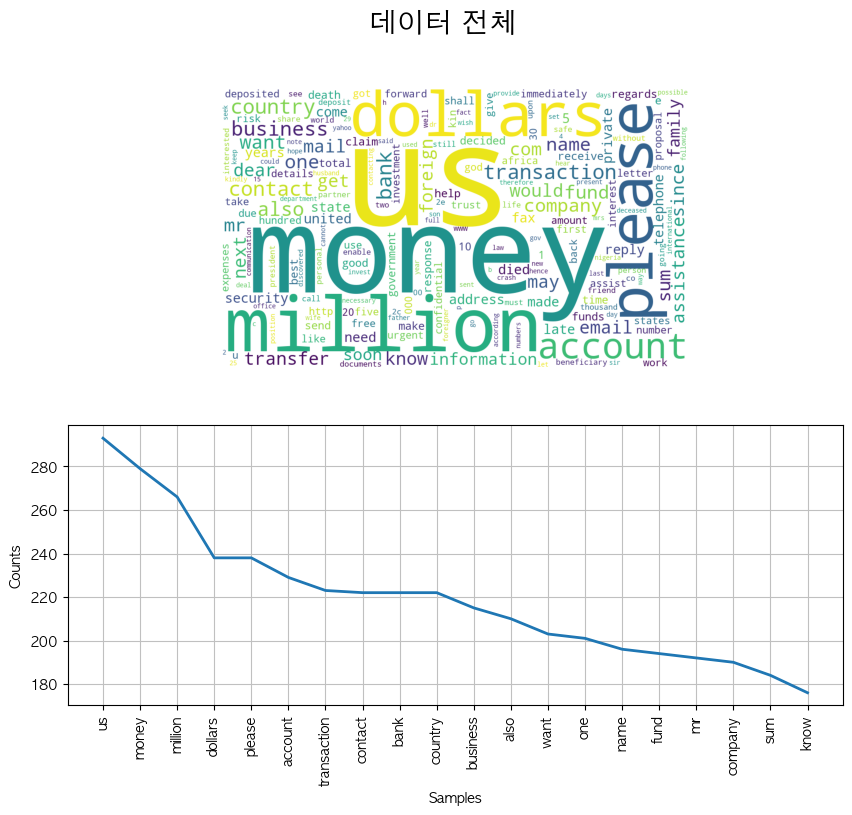

<Figure size 640x480 with 0 Axes>

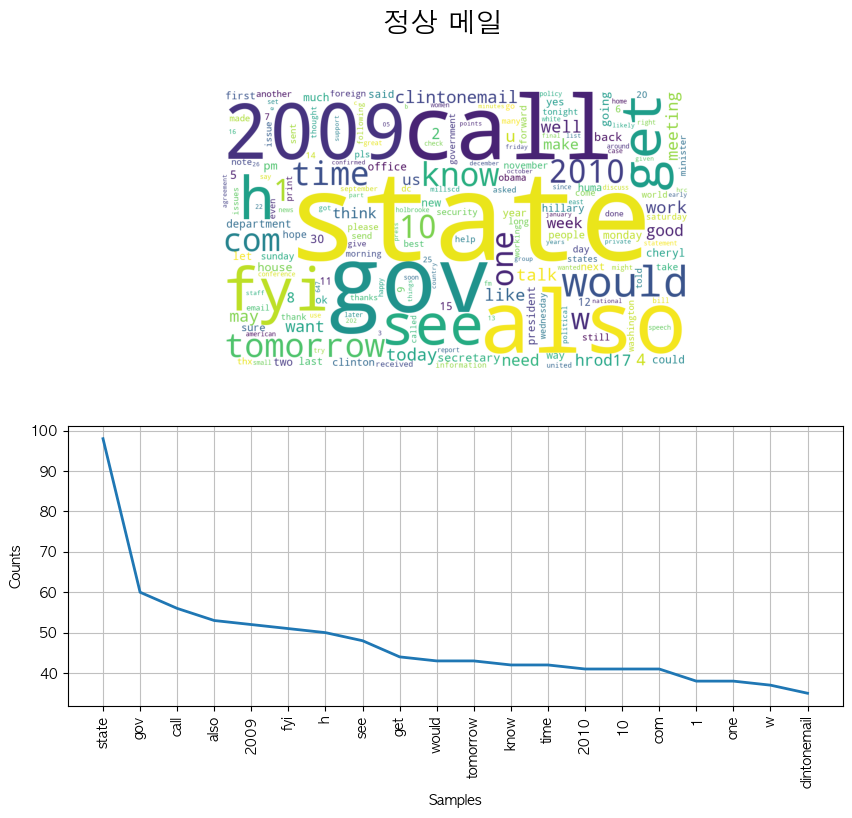

<Figure size 640x480 with 0 Axes>

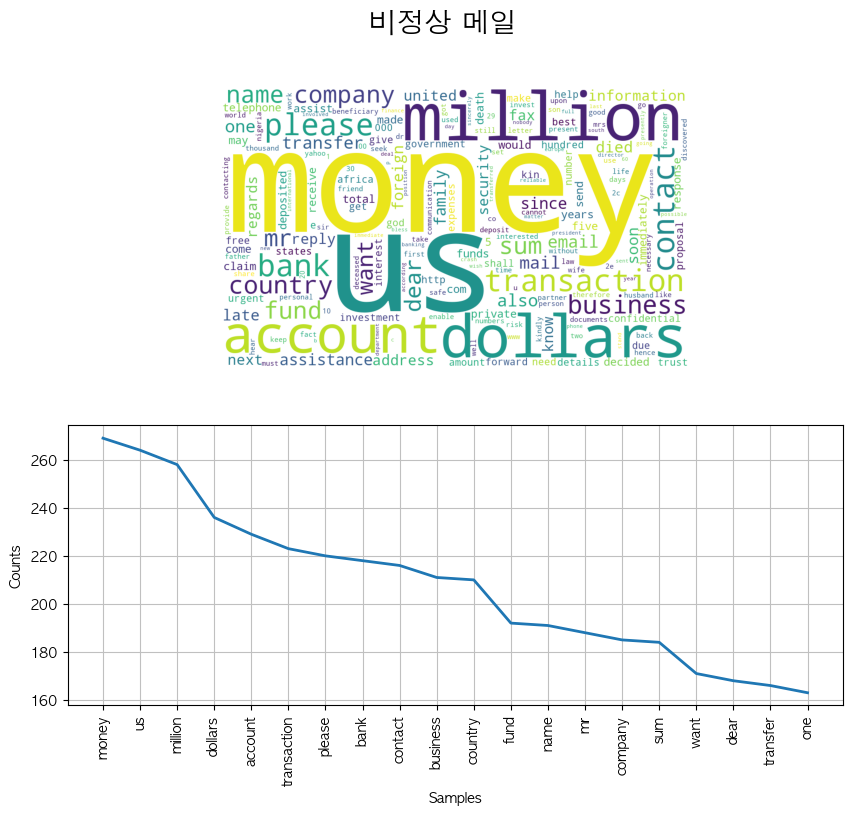

<Figure size 640x480 with 0 Axes>

In [19]:
for i in range(3):
    if i==0:
        tokens = data['Text'] 
        title = "데이터 전체"   
    elif i==1:
        tokens = data.loc[data['Class']==0,'Text']
        title = "정상 메일"  
    else:
        tokens = data.loc[data['Class']==1,'Text']
        title = "비정상 메일"  
        
    tokens = list(itertools.chain(*tokens))
    
    plt.figure(figsize=(10,8))
    plt.suptitle(title, size=20)
    plt.subplot(2,1,1)
    wc = WordCloud(width=1000, height=600, background_color='white', random_state=0)
    fd = FreqDist(tokens)
    plt.imshow(wc.generate_from_frequencies(fd))
    plt.axis('off')
    
    plt.subplot(2,1,2)
    text = Text(tokens)
    text.plot(20)
    plt.tight_layout()
    plt.show()

## 4. 이상탐지 모델링

In [22]:
# !pip install pytorch
# !pip install HuggingFace

from transformers import pipeline

No model was supplied, defaulted to distilbert-base-cased and revision 935ac13 (https://huggingface.co/distilbert-base-cased).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
classifier = pipeline('text-classification')
sample = classifier(data['Text'][0])
sample

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.8555657863616943},
 {'label': 'POSITIVE', 'score': 0.9901549816131592},
 {'label': 'POSITIVE', 'score': 0.9942601919174194},
 {'label': 'POSITIVE', 'score': 0.997986912727356},
 {'label': 'POSITIVE', 'score': 0.9973438382148743},
 {'label': 'POSITIVE', 'score': 0.8750390410423279},
 {'label': 'POSITIVE', 'score': 0.9941042065620422},
 {'label': 'POSITIVE', 'score': 0.9982361793518066},
 {'label': 'POSITIVE', 'score': 0.9910564422607422},
 {'label': 'POSITIVE', 'score': 0.9962445497512817},
 {'label': 'POSITIVE', 'score': 0.9994421601295471},
 {'label': 'POSITIVE', 'score': 0.9998080134391785},
 {'label': 'POSITIVE', 'score': 0.9921756386756897},
 {'label': 'POSITIVE', 'score': 0.9564288854598999},
 {'label': 'POSITIVE', 'score': 0.9977085590362549},
 {'label': 'POSITIVE', 'score': 0.9890222549438477},
 {'label': 'POSITIVE', 'score': 0.99977046251297}]

In [25]:
data.iloc[0,:]

Text          [would, also, mongolia, thought, get, fyi, roy...
Class                                                         0
TextLength                                                  166
Name: 0, dtype: object